# Good vs Corrupt signal

Creating a model using pretrained model

In [55]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


from PIL import Image
from torch.autograd import Variable
import scipy.ndimage

plt.ion()   # interactive mode

In [48]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/Users/youpele/Documents/WZL/12032020/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100, # reduce the batch to 2-4 if you want to images displayed in the method below
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

In [49]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


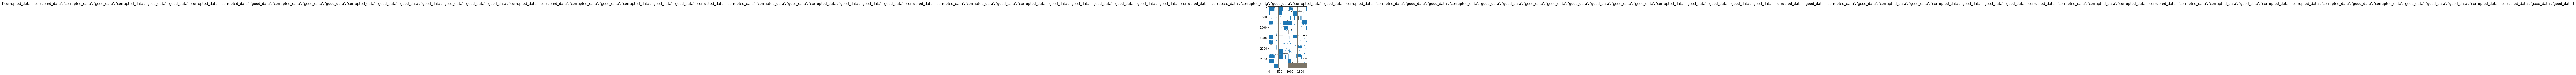

In [50]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [51]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # saving the best model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualizing the model predictions

Generic function to display predictions for a few images

In [52]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


# Finetuning the convnet
Load a pretrained model and reset final fully connected layer.






Finetuning the ConvNet: Instead of random initializaion, the model is initialized using a pretrained network, after which the training proceeds as usual but with a different dataset. Usually the head (or part of it) is also replaced in the network in case there is a different number of outputs. It is common in this method to set the learning rate to a smaller number. This is done because the network is already trained, and only minor changes are required to “finetune” it to a new dataset.

In [53]:



model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features # getting the features to use in the layers we shall add
# reconstructing the last fc layer
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate
It should take while on CPU. On GPU though, it takes less than a minute.

In [54]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
train Loss: 0.1897 Acc: 0.9250
val Loss: 0.0033 Acc: 1.0000

Epoch 1/2
----------
train Loss: 0.0599 Acc: 0.9747
val Loss: 0.0015 Acc: 1.0000

Epoch 2/2
----------
train Loss: 0.0622 Acc: 0.9743
val Loss: 0.0005 Acc: 1.0000

Training complete in 201m 12s
Best val Acc: 1.000000


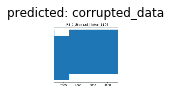

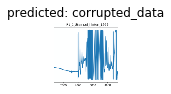

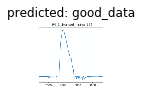

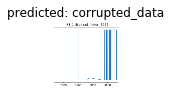

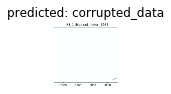

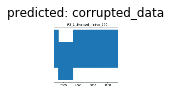

In [56]:
visualize_model(model_ft)

In [57]:
torch.save(model_ft,"/Users/youpele/Documents/WZL/12032020/anotherOneForUs.pth")

In [58]:
model = torch.load("/Users/youpele/Documents/WZL/12032020/anotherOneForUs.pth")

In [59]:
model.eval() 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().




ConvNet as a fixed feature extractor: Here, you “freeze” the weights of all the parameters in the network except that of the final several layers (aka “the head”, usually fully connected layers). These last layers are replaced with new ones initialized with random weights and only these layers are trained.

In [20]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train and evaluate
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [21]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
train Loss: 0.3354 Acc: 0.8713
val Loss: 0.1708 Acc: 0.9971

Epoch 1/2
----------
train Loss: 0.1710 Acc: 0.9377
val Loss: 0.1161 Acc: 1.0000

Epoch 2/2
----------
train Loss: 0.1260 Acc: 0.9548
val Loss: 0.0893 Acc: 1.0000

Training complete in 86m 43s
Best val Acc: 1.000000


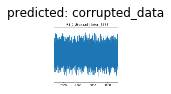

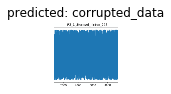

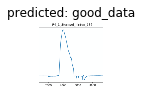

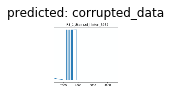

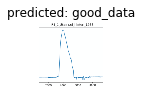

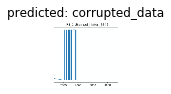

In [26]:
visualize_model(model_conv)

In [41]:
# saving the model, this is different from saving class based models

torch.save(model_conv,"/Users/youpele/Documents/WZL/12032020/anotherOneToday.pth")

In [3]:
# laoding the model, this is different from saving class based models

model = torch.load("/Users/youpele/Documents/WZL/12032020/anotherOneToday.pth")

In [4]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'unused': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/youpele/Documents/WZL/12032020/dataset'
#data_dir = '../small_ds'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['unused']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100, # reduce the batch to 2-4 if you want to images displayed in the method below
                                             shuffle=True, num_workers=0)
              for x in ['unused']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['unused']}
class_names = image_datasets['unused'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
preds = []
labels = []



with torch.no_grad():
    for batch_input, label in dataloaders['unused']:
        batch_input = batch_input.to(device)
        labels.extend(label.tolist())
        outputs = model(batch_input)
        preds.extend(outputs.argmax(dim=1).cpu().tolist())
# print ([class_names[j] for j in preds])
# print ([class_names[j] for j in labels])
print (len(preds), preds)
#print (len(labels), labels)


43 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Predicting a single image

corrupted data is 0

good data is 1

In [40]:
import shutil

pred_s = []
tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image_datasets = datasets.ImageFolder('/Users/youpele/Documents/WZL/12032020/dataset/unused/', tf)

inputs = image_datasets[398]

print (inputs[1])

with torch.no_grad():
    inputs = inputs[0][None, ...].to(device)
    outputs = model(inputs)
    pred_s.append(outputs.argmax(dim=1).cpu().item())
print(pred_s[0])


if pred_s[0] == 1:
    
    
    
    shutil.copy(inputs, '/Users/youpele/Documents/WZL/12032020/dataset/unused/bested/')



2
1


TypeError: expected str, bytes or os.PathLike object, not Tensor

# I always get errors here

In [40]:
# Predicting unseen data


imsize = 50
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    #image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image #.cuda()  #assumes that you're using GPU



image = image_loader("/Users/youpele/Documents/WZL/12032020/corrupt_vs_good_signal/good_data/R1_1_Stempel_hinten_87.png")

model(image)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3 7 7, but got 3-dimensional input of size [4, 50, 75] instead

In [6]:
def predict_image(image_path):
    print("Prediction in progress")
    image = Image.open(image_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 50)
    transformation = transforms.Compose([
        transforms.CenterCrop(50),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)
    
    input1 = transforms.ToPILImage()(image_tensor.float())
    
    
    


    #if torch.cuda.is_available():
        #image_tensor.cuda()

    # Turn the input into a Variable
    #input = Variable(image_tensor)
    input = Variable(input1)

    # Predict the class of the image
    output = model(input)

    index = output.data.numpy().argmax()

    return index



In [7]:
# Import needed packages
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
import requests
import shutil
from io import open
import os
from PIL import Image
import json

index = predict_image("/Users/youpele/Documents/WZL/12032020/dataset/unused/corrupted/R3_1_Stempel_hinten_132.png")

prediction = class_map[str(index)][1]

print("Predicted Class ", prediction)

Prediction in progress


TypeError: img should be PIL Image. Got <class 'torch.Tensor'>